In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import Patch
import pandas as pd
import requests
import os
import io
from shapely.geometry import Point
import numpy as np
import matplotlib.lines as mlines

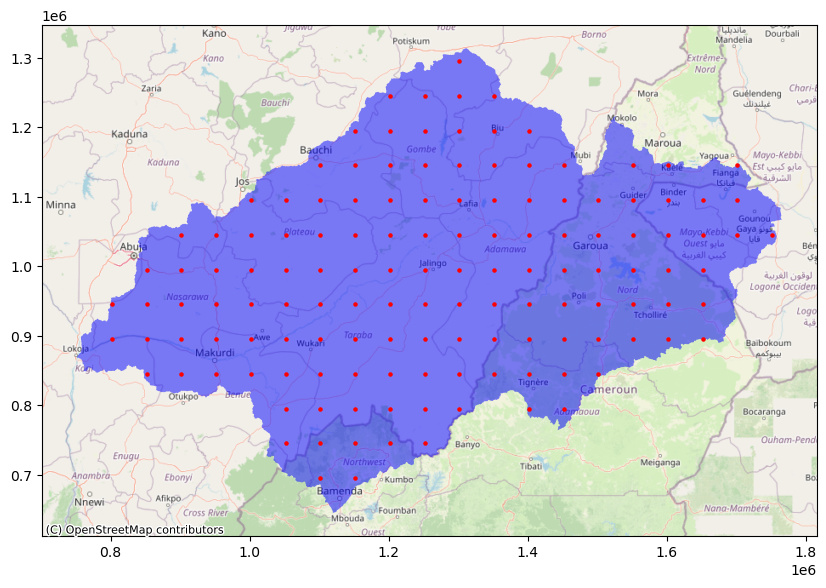

In [2]:
# Read your polygon shapefile (replace 'Boundary.shp' with your actual file)
gdf = gpd.read_file('BasinBoundaryWGS84/Boundary.shp')

# Ensure the shapefile has a CRS
if gdf.crs is None:
    raise ValueError("The shapefile does not have a coordinate reference system defined.")

# Convert to EPSG:3857 (Web Mercator)
gdf = gdf.to_crs(epsg=3857)

# Define grid spacing (adjust as needed, in the units of the projected CRS)
grid_spacing = 50000

# Get the bounding box coordinates
minx, miny, maxx, maxy = gdf.total_bounds

# Create a meshgrid of points within the polygon
x_coords = np.arange(minx, maxx, grid_spacing)
y_coords = np.arange(miny, maxy, grid_spacing)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# Filter points within the polygon
valid_points = [point for point in grid_points if gdf.contains(point).any()]

# Create a GeoDataFrame for the valid points
gdf_grid_points = gpd.GeoDataFrame(geometry=valid_points, crs=gdf.crs)

# Plot the polygon and grid points
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', alpha=0.5)
gdf_grid_points.plot(ax=ax, color='red', markersize=5)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

# Show the plot
plt.show()


In [3]:
# GeoDataFrame with longitude and latitude points
# GeoDataFrame with points in EPSG:4326 (WGS84) CRS

# Convert to EPSG:3857 (Web Mercator) for projected coordinates (x/y)
gdf_grid_points = gdf_grid_points.to_crs(epsg=4326)
gdf_grid_points_shp = gdf_grid_points.to_crs(epsg=3857)

# Extract x (longitude) and y (latitude) coordinates from the geometry
gdf_grid_points['Longitude'] = gdf_grid_points.geometry.x
gdf_grid_points['Latitude'] = gdf_grid_points.geometry.y

# Export grid points coordinates to a CSV file
output_csv = 'BoundaryGridPoints/grid_points_coordinates.csv'
gdf_grid_points[['Latitude', 'Longitude']].to_csv(output_csv, index=False)
output_shp = 'BoundaryGridPoints/grid_points.shp'
gdf_grid_points_shp.to_file(output_shp, index=False)

print(f"Grid points coordinates exported to {output_csv}")
print(f"Grid points coordinates exported to {output_shp}")

Grid points coordinates exported to BoundaryGridPoints/grid_points_coordinates.csv
Grid points coordinates exported to BoundaryGridPoints/grid_points.shp


In [4]:
print(gdf_grid_points.head())

                  geometry  Longitude  Latitude
0  POINT (7.20332 8.01652)   7.203324  8.016516
1  POINT (7.20332 8.46104)   7.203324  8.461037
2  POINT (7.65248 7.57151)   7.652482  7.571509
3  POINT (7.65248 8.01652)   7.652482  8.016516
4  POINT (7.65248 8.46104)   7.652482  8.461037


In [5]:
parameters = [
    'CLRSKY_SFC_SW_DWN',
    'ALLSKY_SFC_SW_DWN',
    'ALLSKY_KT',
    'WS2M',
    'WS10M',
    'WS50M',
    'T2M',
    'T10M',
    'TS',
    'QV2M',
    'RH2M',
    'PRECTOTCORR',
    'PS',
    'WD2M',
    'WD10M',
    'WD50M',
    'ALLSKY_SFC_UV_INDEX',
    'ALLSKY_SRF_ALB',
    'ALLSKY_SFC_SW_UP',
    'ALLSKY_SFC_SW_DNI',
    'ALLSKY_SFC_SW_DIFF',
    'ALLSKY_SFC_LW_DWN',
    'ALLSKY_SFC_LW_UP',
    'CLOUD_AMT_DAY',
    'DIRECT_ILLUMINANCE',
    'GLOBAL_ILLUMINANCE',
    'DIFFUSE_ILLUMINANCE',
    'ALLSKY_SFC_PAR_TOT',
    'ALLSKY_SFC_UVA',
    'ALLSKY_SFC_UVB',
    'CLRSKY_SRF_ALB',
    'CLRSKY_SFC_LW_DWN',
    'CLRSKY_SFC_LW_UP',
    'CLRSKY_SFC_PAR_TOT',
    'CLRSKY_SFC_SW_DIFF',
    'CLRSKY_SFC_SW_DNI',
    'CLRSKY_SFC_SW_UP',
    'CLOUD_OD',
    'U2M',
    'U10M',
    'U50M',
    'MIDDAY_INSOL',
    'V2M',
    'V10M',
    'V50M',
    'PBLTOP',
    'PW',
    'SLP',
    'RHOA',
    'ZENITH_LUMINANCE'
]

In [6]:
rain_parameter = 'PRECTOTCORR'

In [9]:
# Read coordinates from CSV
csv_file = 'BoundaryGridPoints/grid_points_coordinates.csv'
df = pd.read_csv(csv_file)

# Define API parameters
start_date = '19810101'
end_date = '20240101'
community = 'SB'
rain_parameter = 'PRECTOTCORR'

# Function to download data for a specific coordinate pair
def download_data(latitude, longitude):
    url = f'https://power.larc.nasa.gov/api/temporal/daily/point?start={start_date}&end={end_date}&latitude={latitude}&longitude={longitude}&community={community}&parameters={rain_parameter}&format=CSV'
    response = requests.get(url)
    
    if response.status_code == 200:
        filename = f'data_{latitude}_{longitude}.csv'
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Data for latitude {latitude} and longitude {longitude} downloaded successfully.")
    else:
        print(f"Error downloading data for latitude {latitude} and longitude {longitude}. Status code: {response.status_code}")

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Validate coordinates
    if not (-90 <= latitude <= 90) or not (-180 <= longitude <= 180):
        print(f"Invalid coordinates: Latitude {latitude}, Longitude {longitude}")
        continue
    
    # Download data for the current coordinate pair
    download_data(latitude, longitude) 
    # --> I commented this out, undo this to redownload

Data for latitude 8.016516014323393 and longitude 7.203324308726448 downloaded successfully.
Data for latitude 8.461036952645479 and longitude 7.203324308726448 downloaded successfully.
Data for latitude 7.571508843038432 and longitude 7.652481950786209 downloaded successfully.
Data for latitude 8.016516014323393 and longitude 7.652481950786209 downloaded successfully.
Data for latitude 8.461036952645479 and longitude 7.652481950786209 downloaded successfully.
Data for latitude 8.905045463075526 and longitude 7.652481950786209 downloaded successfully.
Data for latitude 7.571508843038432 and longitude 8.101639592845968 downloaded successfully.
Data for latitude 8.016516014323393 and longitude 8.101639592845968 downloaded successfully.
Data for latitude 8.461036952645479 and longitude 8.101639592845968 downloaded successfully.
Data for latitude 8.905045463075526 and longitude 8.101639592845968 downloaded successfully.
Data for latitude 9.348515504033744 and longitude 8.101639592845968 do

In [10]:
import shutil
import glob

# Define the current directory and the new directory
current_directory = "C:\\GIS\\OEA Consults LTD\\Dr Tobi\\Climate-Variability"
new_directory = "C:\\GIS\\OEA Consults LTD\\Dr Tobi\\Climate-Variability\\RainfallData"

# Create the new directory if it doesn't exist
if not os.path.exists(new_directory):
    os.makedirs(new_directory)

# Define the name format you are looking for using glob pattern
name_format = "data_*.csv"
search_pattern = os.path.join(current_directory, name_format)

# Find all files matching the name format
matching_files = glob.glob(search_pattern)

# Move each matching file to the new directory
for current_file in matching_files:
    filename = os.path.basename(current_file)
    new_file = os.path.join(new_directory, filename)
    shutil.move(current_file, new_file)

print("Files have been moved successfully.")


Files have been moved successfully.


In [13]:
import os
import pandas as pd
import io

# Directory where downloaded CSV files are stored
download_dir = "C:\\GIS\\OEA Consults LTD\\Dr Tobi\\Climate-Variability\\RainfallData"

# Initialize an empty list to store cleaned DataFrames
cleaned_dataframes = []

# Function to extract longitude and latitude from the filename
def extract_lon_lat(filename):
    try:
        # Remove the extension and split by underscore
        name, _ = os.path.splitext(filename)
        parts = name.split('_')
        if len(parts) == 3 and parts[0] == 'data':
            longitude = float(parts[1])
            latitude = float(parts[2])
            return longitude, latitude
        else:
            print(f"Filename {filename} does not match the expected format.")
            return None, None
    except ValueError as e:
        return None, None

# Function to clean each CSV file
def clean_csv(file_path, longitude, latitude):
    with open(file_path, 'r') as file:
        data = file.read()

    # Split into header and data parts
    data_parts = data.split('-END HEADER-')
    if len(data_parts) != 2:
        return None

    actual_data = data_parts[1].strip()

    # Create DataFrame from actual data lines
    try:
        data_df = pd.read_csv(io.StringIO(actual_data))

        # Add Longitude and Latitude columns
        data_df['Longitude'] = longitude
        data_df['Latitude'] = latitude

        return data_df
    except pd.errors.EmptyDataError:
        print(f"No columns to parse from file {file_path}")
        return None

# Iterate over all downloaded CSV files
for filename in os.listdir(download_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(download_dir, filename)

        # Extract longitude and latitude from file name
        longitude, latitude = extract_lon_lat(filename)
        if longitude is None or latitude is None:
            continue  # Skip files that don't match expected format

        # Clean the CSV file and add to cleaned_dataframes
        cleaned_df = clean_csv(file_path, longitude, latitude)
        if cleaned_df is not None:
            cleaned_dataframes.append(cleaned_df)

# Concatenate all cleaned DataFrames into one
if cleaned_dataframes:
    combined_df = pd.concat(cleaned_dataframes, ignore_index=True)

    # Reorder columns with Longitude and Latitude first
    columns = ['Longitude', 'Latitude'] + [col for col in combined_df.columns if col not in ['Longitude', 'Latitude']]
    combined_df = combined_df[columns]

    # Save combined DataFrame to a CSV file
    output_csv = 'combinedRainfallData_cleaned.csv'
    combined_df.to_csv(output_csv, index=False)
    print(f"Combined and cleaned precipitation data saved to {output_csv}")
else:
    print("No data downloaded or cleaned.")


Combined and cleaned precipitation data saved to combinedRainfallData_cleaned.csv


In [15]:
df = pd.read_csv('combinedRainfallData_cleaned.csv')
df.isna().sum()

Longitude      0
Latitude       0
YEAR           0
MO             0
DY             0
PRECTOTCORR    0
dtype: int64

In [16]:
df.head()

,Longitude,Latitude,YEAR,MO,DY,PRECTOTCORR
0,10.233737,10.347428,1981,1,1,0.0
1,10.233737,10.347428,1981,1,2,0.0
2,10.233737,10.347428,1981,1,3,0.0
3,10.233737,10.347428,1981,1,4,0.0
4,10.233737,10.347428,1981,1,5,0.0


In [17]:
# Path to the input and output CSV file
input_csv_file = 'combinedRainfallData_cleaned.csv'
output_csv_file = 'YearlyRainfallData_sum.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(input_csv_file)

# Group by 'Longitude', 'Latitude', and 'YEAR', then calculate the sum of 'PRECTOTCORR' for each group
sum_rainfall_year = df.groupby(['Longitude', 'Latitude', 'YEAR'])['PRECTOTCORR'].sum().reset_index()

# Save the result to a new CSV file
sum_rainfall_year.to_csv(output_csv_file, index=False)

print("Sum of PRECTOTCORR column per year with coordinates has been saved to:", output_csv_file)


Sum of PRECTOTCORR column per year with coordinates has been saved to: YearlyRainfallData_sum.csv


In [18]:
# Path to the input and output CSV file
input_csv_file = 'combinedRainfallData_cleaned.csv'
output_csv_file = 'YearlyRainfallData_avg.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(input_csv_file)

# Group by 'Longitude', 'Latitude', and 'YEAR', then calculate the sum of 'PRECTOTCORR' for each group
avg_rainfall_year = df.groupby(['Longitude', 'Latitude', 'YEAR'])['PRECTOTCORR'].mean().reset_index()

# Save the result to a new CSV file
avg_rainfall_year.to_csv(output_csv_file, index=False)

print("Average of PRECTOTCORR column per year with coordinates has been saved to:", output_csv_file)


Average of PRECTOTCORR column per year with coordinates has been saved to: YearlyRainfallData_avg.csv


In [32]:
filtered_df = df[(df['YEAR'] == 2024) & (df['PRECTOTCORR'] > 0)]
print(filtered_df)

         Longitude   Latitude  YEAR  MO  DY  PRECTOTCORR
15401    10.233737  10.347428  2023   3   3         0.13
15402    10.233737  10.347428  2023   3   4        20.58
15403    10.233737  10.347428  2023   3   5       135.34
15404    10.233737  10.347428  2023   3   6         6.31
15405    10.233737  10.347428  2023   3   7         0.02
...            ...        ...   ...  ..  ..          ...
2151664   9.791421   9.898270  2023  11   5         0.70
2151674   9.791421   9.898270  2023  11  15         0.46
2151675   9.791421   9.898270  2023  11  16         0.08
2151684   9.791421   9.898270  2023  11  25         0.26
2151685   9.791421   9.898270  2023  11  26         0.02

[32368 rows x 6 columns]


In [52]:
# Read the CSV file into a DataFrame
df = pd.read_csv(input_csv_file)
df.shape

(2151722, 6)

In [34]:
# Path to the input and output CSV file
input_csv_file = 'combinedRainfallData_cleaned.csv'
output_csv_file = 'MonthlyRainfallData_sum.csv'

# Group by 'Longitude', 'Latitude', 'MO' (month), and 'YEAR', then calculate the sum of 'PRECTOTCORR' for each group
sum_per_month = df.groupby(['Longitude', 'Latitude', 'MO', 'YEAR'])['PRECTOTCORR'].sum().reset_index()

# Save the result to a new CSV file
sum_per_month.to_csv(output_csv_file, index=False)

print("Sum of PRECTOTCORR column per month with coordinates has been saved to:", output_csv_file)

Sum of PRECTOTCORR column per month with coordinates has been saved to: MonthlyRainfallData_sum.csv


In [43]:
# Path to the input and output CSV file
input_csv_file = 'combinedRainfallData_cleaned.csv'
output_csv_file = 'MonthlyRainfallData_avg.csv'

# Group by 'Longitude', 'Latitude', 'MO' (month), and 'YEAR', then calculate the sum of 'PRECTOTCORR' for each group
avg_per_month = df.groupby(['Longitude', 'Latitude', 'MO', 'YEAR'])['PRECTOTCORR'].mean().reset_index()

# Save the result to a new CSV file
avg_per_month.to_csv(output_csv_file, index=False)

print("Average of PRECTOTCORR column per month with coordinates has been saved to:", output_csv_file)

Average of PRECTOTCORR column per month with coordinates has been saved to: MonthlyRainfallData_avg.csv


In [81]:
# Find the highest value in the 'PRECTOTCORR' column
highest_rainfall = df['PRECTOTCORR'].max()

# Find the row with the highest value
highest_rainfall_row = df[df['PRECTOTCORR'] == highest_rainfall]

print("Highest rainfall value:", highest_rainfall)
print("Details of the highest rainfall entry:")
print(highest_rainfall_row)


Highest rainfall value: 1188.93
Details of the highest rainfall entry:
         Longitude  Latitude  YEAR  MO  DY  PRECTOTCORR
2135427   9.791421  9.449113  2022   5  23      1188.93


In [82]:
# Find the highest value in the 'PRECTOTCORR' column per year
highest_rainfall_per_year = df.loc[df.groupby('YEAR')['PRECTOTCORR'].idxmax()]

# Select relevant columns
highest_rainfall_per_year = highest_rainfall_per_year[['YEAR', 'Longitude', 'Latitude', 'MO', 'DY', 'PRECTOTCORR']]

output_csv_file = 'HighestRainfallYearly.csv'

highest_rainfall_per_year.to_csv(output_csv_file, index=False)
# Display the results
print("Highest rainfall per year:")
print(highest_rainfall_per_year)


Highest rainfall per year:
         YEAR  Longitude   Latitude  MO  DY  PRECTOTCORR
361525   1981   6.233834   9.898270  10  15        51.65
691698   1982   7.571509  13.491531   9  27        87.14
550654   1983   7.126042   9.449113   8   3       120.77
441132   1984   6.680141   9.898270   9  26        89.90
520030   1985   7.126042  12.593216   9  29        58.95
378899   1986   6.680141  10.347428   5  10        72.51
143743   1987  10.233737  15.288162   7  18        97.32
945126   1988   8.016516  14.389847   7  29        88.17
961217   1989   8.016516  14.839004   8  18        73.28
380535   1990   6.680141  10.347428  11   1        53.63
537903   1991   7.126042  13.042374   9   5        50.61
1841797  1992   9.348516   8.101640   6  27        58.98
695689   1993   7.571509  13.491531   8  31        84.57
224849   1994  10.675437  11.694901   8   6       113.54
366621   1995   6.233834   9.898270   9  28        76.23
445400   1996   6.680141   9.898270   6   3        87.13
9169

In [83]:
# Find the highest value in the 'PRECTOTCORR' column per year and geographical point
highest_rainfall_per_year_point = df.loc[df.groupby(['YEAR', 'Longitude', 'Latitude'])['PRECTOTCORR'].idxmax()]

# Select relevant columns
highest_rainfall_per_year_point = highest_rainfall_per_year_point[['YEAR', 'Longitude', 'Latitude', 'MO', 'DY', 'PRECTOTCORR']]

# Output CSV file path
output_csv_file = 'HighestRainfallYearly2.csv'

# Save the DataFrame to a CSV file
highest_rainfall_per_year_point.to_csv(output_csv_file, index=False)

# Display the results
print("Highest rainfall per year and point:")
print(highest_rainfall_per_year_point)


Highest rainfall per year and point:
        YEAR  Longitude   Latitude  MO  DY  PRECTOTCORR
361525  1981   6.233834   9.898270  10  15        51.65
345802  1981   6.233834  10.347428   9  28        37.03
424181  1981   6.680141   9.449113   4  30        50.14
440013  1981   6.680141   9.898270   9   3        36.59
377189  1981   6.680141  10.347428   9   3        35.32
...      ...        ...        ...  ..  ..          ...
282707  2024  11.116496  10.796585   1   1         0.00
298413  2024  11.116496  11.245743   1   1         0.00
314119  2024  11.116496  11.694901   1   1         0.00
329825  2024  11.116496  12.144058   1   1         0.00
345531  2024  11.556889  11.694901   1   1         0.00

[6028 rows x 6 columns]
